# micapipe v0.2.0 | Group QC

In [18]:
from xhtml2pdf import pisa
import sys
import pandas as pd
import numpy as np
import os
import glob
import json

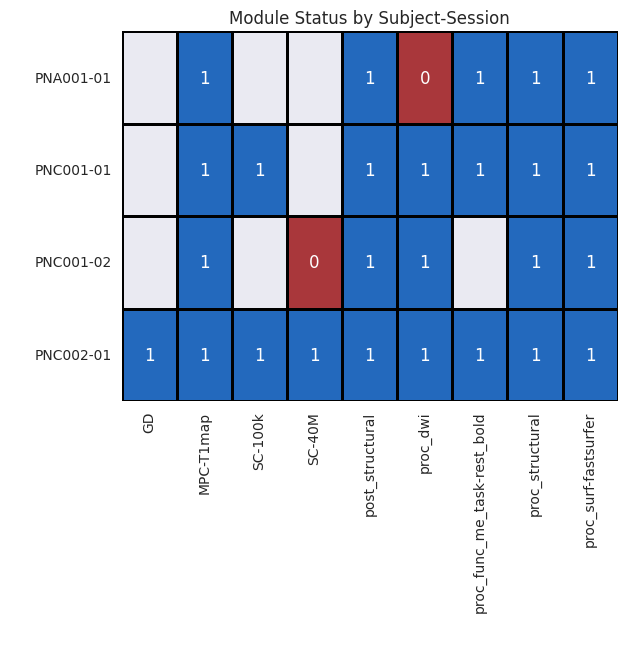

In [19]:
# Arguments
sub = 'HC062'
out = '/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0'
bids = '/data_/mica3/BIDS_PNI/rawdata'
ses = '01'
tmpDir = '/tmp/'
version = 'v0.2.0'

# Optional inputs:
# Session
if ses == "":
    ses_number = "Not defined"
    sbids = sub
else:
    ses_number = ses
    ses = "ses-" + ses_number
    sbids = sub + "_" + ses

derivatives = out.split('/micapipe_v0.2.0')[0]

# Path to MICAPIPE
MICAPIPE=os.popen("echo $MICAPIPE").read()[:-1]

# List all the jsons
if ses_number == "Not defined":
    jsons = sorted(glob.glob(out+'/sub*/QC/*json'))
else:
    jsons = sorted(glob.glob(out+'/sub*/ses*/QC/*json'))

# Sort the JSON files by creation time (newest at the bottom)
jsons = sorted(jsons, key=lambda x: os.path.getctime(x))
                   
# Define the keys to extract from each JSON file
keys_to_extract = ['Subject', 'Session', 'Module', 'Status', 'Progress', 'User', 'Workstation', 'Date', 'Processing', 'micapipeVersion']

# Initialize an empty list to hold the individual dataframes
dataframes = []

# Loop through each JSON file in the specified directory
for file_name in jsons:

    # Read in the JSON data from the file
    with open(file_name, 'r') as f:
        json_data = json.load(f)

    # Extract the desired keys and create a dataframe
    data = {k: [] for k in keys_to_extract}
    
    for k in keys_to_extract:
        data[k].append(json_data[k])

    df = pd.DataFrame(data)

    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the individual dataframes into a single dataframe
result = pd.concat(dataframes, ignore_index=True)

# Save the resulting dataframe as a CSV file
result.to_csv(out+'/micapipe_processed_sub.csv', index=False)

# --------------------------------------------------------
# Create an empty dictionary to hold the data
data = {}

# Loop through each row in the concatenated dataframe
for i in range(len(result)):

    # Extract thesubject and session and module and status from the row
    subject = result['Subject'][i]
    session = result['Session'][i]
    module = result['Module'][i]
    status = result['Status'][i]

    # Convert the status to a binary value
    if status == 'INCOMPLETE':
        value = 0
    elif status == 'COMPLETED':
        value = 1
    else:
        value = np.nan

    # Add the value to the data dictionary
    key = f"{subject}-{session}"
    if key not in data:
        data[key] = {}
    data[key][f"{module}"] = value

# Create a dataframe from the data dictionary
df = pd.DataFrame(data).T

# Sort the columns by module and status
df = df.reindex(sorted(df.columns), axis=1)

# Sort the rows by subject and session
df = df.sort_index()

import seaborn as sns
import matplotlib.pyplot as plt

# background
sns.set_style('dark')
sns.heatmap(df, cmap='vlag_r', annot=True, cbar=False, fmt='.0f', linewidths=1, linecolor='black', annot_kws={'fontsize':12, 'color':'white'})

# Set the x and y axis labels to white
plt.xlabel('Module-Status', fontsize=14, color='white')
plt.ylabel('Subject-Session', fontsize=14, color='white')

# Set the plot title and axis labels
plt.title('Module Status by Subject-Session')
plt.xlabel('Module-Status')
plt.ylabel('Subject-Session')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [20]:
# Get progress percentage
module_progress = np.sum(df, axis=0)/len(df)
type(module_progress)

pandas.core.series.Series

Text(0.5, 1.0, 'Module Progress')

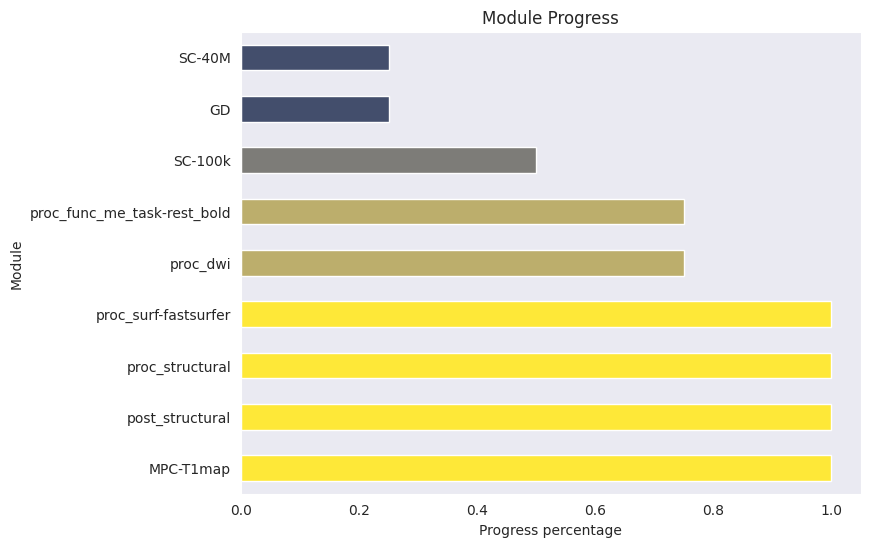

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import cividis

# sort the series by values
module_progress_sorted = module_progress.sort_values(ascending=False)

# create the horizontal barplot
fig, ax = plt.subplots(figsize=(8, 6))
module_progress_sorted.plot.barh(ax=ax, color=cividis(module_progress_sorted))

# set the x and y axis labels and title
ax.set_xlabel('Progress percentage')
ax.set_ylabel('Module')
ax.set_title('Module Progress')


# Thickness group level cortical thickness

# Geodesic Distance
# DWI maps
# SC
# func series